In [1]:
dsfolder = "G:\\My Drive\\PalankerLab\\retinal modeling\\datasets\\"

In [2]:
import json
import numpy as np
import time
import matplotlib.pyplot as plt
import os
import timeit
import random
from itertools import groupby, product
from scipy import optimize,stats
import shapely
from shapely.geometry import Polygon, Point

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda
import torch.nn.functional as F
import torch.nn.init
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.autograd import Variable

import numba
from numba import cuda

%matplotlib inline

In [3]:
# convert times among three systems: real, mea, wn

def timeConversion(t, source = "mea", target = "wn", WNType = "N"):
  
  meaRepRate = 20000
  if WNType == "N":
    stimRepRate = 1 / (33.27082098251457/1000)
  else:
    stimRepRate = 1 / (49.90624667553192/1000)
  
  if source == "mea":
    t = np.divide(t, meaRepRate)
  elif source == "wn":
    t = np.divide(t, stimRepRate)
  elif source == "ms":
    t = np.divide(t, 1000)
  
  if target == "mea":
    t = np.multiply(t, meaRepRate)
  elif target == "wn":
    t = np.multiply(t, stimRepRate)
  elif target == "ms":
    t = np.multiply(t, 1000)
  
  return t


# =====================
# compute STA

def getSTA(experiment,  whiteNoise, staLength = 25, verbose = "on", normalize = False):

  startTime = experiment['info']['startTime']
  skipped = 0
  STA = np.zeros((staLength * 2, experiment['info']['WNShape'][0], experiment['info']['WNShape'][1]))

  st_wn = timeConversion(np.array(experiment["spikeTimes"]) - startTime, source = "mea", target = "wn", WNType = experiment['info']['WNType'])
  st_frame = np.ceil(st_wn).astype(int)
  st_frame = st_frame[st_frame >= (staLength * 2 - 1)]

  #for i, st in enumerate(experiment["spikeTimes"]):
  for i, st in enumerate(st_frame):
    # if st < timeConversion(staLength * 2 - 1, source = "wn", target = "mea", WNType = experiment['info']['WNType']) + startTime:
    #   skipped += 1
    #   continue
    if i % 2000 == 0 and verbose == "on":
      print(f"Computing spike {i} out of {len(experiment['spikeTimes'])}; using frame {st_frame}")

    # st_wn = timeConversion(st - startTime, source = "mea", target = "wn")
    # st_frame = int(np.ceil(st_wn))
    shift = 0
    try:
      STA += whiteNoise[st-staLength * 2 + 1 + shift:st + 1 + shift, :, :]
    except:
      print(f"Terminated on spike #{i}")
      print(f"Spike time at {st}. White noise length: {whiteNoise.shape[0]}")
      break

  STA /= (i - 1 - skipped)
  if normalize == True: STA = (STA - np.mean(STA)) / (STA.max(axis = 0) - STA.min(axis = 0))
  
  return STA


# =====================
# Bin generator signals

def getGenerator(experiment, whiteNoise, STA):
  print(f"STA dimensions: {STA.shape}")
  print(f"WN dimensions: {whiteNoise.shape}")
  MAX = STA.max(axis = None)
  MIN = STA.min(axis = None)
  MEAN = np.mean(STA, axis = None)
  
  stimulus = np.zeros(STA.shape)
  numStim = whiteNoise.shape[0] - STA.shape[0] + 1
  generator = np.zeros((numStim,))
  #kernel = np.flip(STA, axis = 0)
  #kernel = (STA[:,:,::-1] - MEAN) / (MAX - MIN)
  kernel = (STA - MEAN) / (MAX - MIN)
  
  for i in range(numStim):
    generator[i] = np.sum(np.multiply(whiteNoise[i:i + STA.shape[0],:,:], kernel), axis = None)
  
  return np.array(generator)


# =====================
# Get responses

def getResponse(experiment):
  refreshPeriod = timeConversion(experiment['info']['refreshPeriod'], source = "ms", target = "mea", WNType = experiment['info']['WNType'])
  spikeTimes = np.array(experiment['spikeTimes']) - experiment['info']['startTime'] - (STA.shape[0]) * refreshPeriod
#   spikeTimes = np.floor(spikeTimes)
  spikeTimes = np.floor(spikeTimes[spikeTimes > 0] / refreshPeriod)
  response = [len(list(group)) for key, group in groupby(spikeTimes)]
  
#   respLen = int(experiment['info']['wn']['duration'])
#   response = np.zeros((respLen,))
  
#   for i in range(respLen):
#     for j in range(len(spikeTimes)):
#       if np.floor(spikeTimes[j] / refreshPeriod) == i:
#         response[i] += 1
#       else:
#         if j == 0: break
#         spikeTimes = np.delete(spikeTimes, np.arange(j))
#         break

  return np.array(response)


# =====================
# Compute nonlinear function

def getNL(generator, response, shift, nbins = 800):
  MAX = np.max(generator)
  MIN = np.min(generator)
  INT = (MAX - MIN) / nbins
  
  counts = np.zeros((nbins, 2))
  length = np.min([generator.shape[0] , response.shape[0]])
  
  for i in range(length):
    if i+shift > len(response)-1: break
    binNum = int(np.ceil((generator[i] - MIN) / INT) + 1)
    counts[binNum, 0] += response[i+shift]
    counts[binNum, 1] += 1
  
  return np.divide(counts[:,0], counts[:,1])


# =====================
# Get average stimulus given a generator

def stimulationFromGenerator(whiteNoise, STA, generator, signal, width, shift, plot = "on"):
  idx = np.where(((np.absolute(generator - signal) < width / 2)) == 1)[0]
  idx = np.array(idx).astype(dtype = int)
  avgStim = np.zeros(STA.shape)
  for _,i in enumerate(idx):
    avgStim += whiteNoise[i + shift:i + shift + STA.shape[0], :, :]
  
  avgStim /= len(idx)
  
  if plot == "on":
    plt.figure(num = None, figsize = (np.ceil(avgStim.shape[0]/2),2))
    for i in range(avgStim.shape[0]):
      plt.subplot(2, np.ceil(avgStim.shape[0]/2), i+1)
      plt.imshow(avgStim[i,:,:])
      plt.clim(avgStim.min(axis = None), avgStim.max(axis = None))
      plt.axis('off')
    
  return avgStim, idx


# =====================
# Get raster data with a given generator range

def rasterFromGenerator(experiment, generator, genRange, t):
  
  refreshPeriod = timeConversion(experiment['info']['refreshPeriod'], source = 'ms', target = 'mea', WNType = experiment['info']['WNType'])
  #print(refreshPeriod)
  generator = np.array(generator)
  staLength = experiment['info']['STALength']
  idx = np.where(((np.absolute(generator - genRange[0]) < genRange[1] / 2)) == 1)[0]
  trialTimes = timeConversion(idx, 
                              source = "wn", 
                              target = "mea", 
                              WNType = experiment['info']['WNType'])
  trialTimes += experiment['info']['startTime'] + (staLength-4) * refreshPeriod
  spikeTimes = np.array(experiment['spikeTimes'])
  
  raster = dict()
  for i in range(len(trialTimes)):
    spikes = np.where(np.logical_and(spikeTimes > trialTimes[i], spikeTimes < trialTimes[i] + t))[0]
    trial = np.array([spikeTimes[j] for j in spikes]) - trialTimes[i] #- (staLength-1) * refreshPeriod
    
    #spikeTimes.remove(spikeTimes[(trialTimes[i] - spikeTimes).any()])
    raster[i] = trial
    
  return raster, idx


# =====================
# Plot raster

def plotRaster(raster, WNType):
  for i, trial in raster.items():
    if len(trial) == 0: continue
    trial = timeConversion(trial, source = "mea", target = "real", WNType = WNType)
    plt.scatter(trial, i * np.ones(len(trial)), c = 'tab:blue', s = 1)
  return None


# =====================
# Lists in dictionary to Numpy arrays

def dictLists2npArray(d):
  for k, v in d.items():
    if isinstance(v, dict):
      dictLists2npArray(v)
    elif isinstance(v, list):
      d[k] = np.array(v)


# =====================
# Make geometries

def makeHexagon(l, s = 1):
  a1 = [s * np.cos(np.pi/6), s * np.sin(np.pi/6)]
  corners = [np.array(l)]
  corners.append(l + np.array([a1[0], -a1[1]]))
  corners.append(l + np.array([2 * a1[0], 0]))
  corners.append(l + np.array([2 * a1[0], s]))
  corners.append(l + np.array([a1[0], s + a1[1]]))
  corners.append(l + np.array([0, s]))
  return corners

def makeRectangle(l = (0,0), dim = (1,1)):
  corners = [np.array(l)]
  corners.append(l + np.array([dim[0], 0]))
  corners.append(l + np.array([dim[0], dim[1]]))
  corners.append(l + np.array([0, dim[1]]))
  return corners

def makeBar(center, width, angle):
  R = np.array([[np.cos(angle), -np.sin(angle)], 
                [np.sin(angle), np.cos(angle)]])
  center = np.array(center)
  corners = np.array([[-40, -width/2],
             [-40, width/2],
             [40, width/2],
             [40, -width/2]])
  newCorners = np.matmul(R,corners.T)
  newCorners = newCorners.T + center
  return newCorners

def makeLandoltC(center, diameter, angle):
  R = np.array([[np.cos(angle), -np.sin(angle)], 
                [np.sin(angle), np.cos(angle)]])
  center = np.array(center)
  outer = Polygon(Point(*center).buffer(diameter/2))
  inner = Polygon(Point(*center).buffer (diameter/2 - diameter/5))
  ring = outer.difference(inner)
  opening = np.array([[0, -diameter/10],
                     [diameter/2, -diameter/10],
                     [diameter/2, diameter/10],
                     [0, diameter/10]])
  opening = Polygon(np.matmul(R,opening.T).T + center)
  landoltC = ring.difference(ring.intersection(opening))
  return landoltC
  

# =====================
# Make bar for hexgonal lattice

def buildBarStimulus(params, visualize = False):

  center = params['center']
  width = params['width']
  angle = params['angle']
  startFrame = params['startFrame']
  dims = params['dims']

  origin = [0, 0]
  hexCoord = makeHexagon(origin, 1)
  hx = Polygon(hexCoord)

  xlist = np.arange(dims[1])
  ylist = np.arange(dims[2])

  xylist = list(product(xlist, ylist))
  hx_dict = dict()
  hx_coord = []

  bar = Polygon(makeBar(center, width, angle))
  inter = dict()

  for x, y in xylist:
    xx = np.cos(np.pi/6) * (2*x+y-2*np.floor(y/2))
    yy = 1.5 * y
    hx_coord.append([xx, yy])
    hx_dict[(x,y)] = Polygon(makeHexagon([xx,yy], 1))
    inter[(x,y)] = hx_dict[(x,y)].intersection(bar).area / hx_dict[(x,y)].area #/ 2 + 0.5

  outStim = np.zeros((dims[0],dims[1],dims[2])) #* 0.5
  for x in range(dims[1]):
    for y in range(dims[2]):
      outStim[startFrame:, x, y] = inter[(x,y)]

  if visualize == True:
    plt.subplot(1,2,1)

    for (x,y), hx in hx_dict.items():
      xl, yl = hx.exterior.xy
      plt.plot(xl,yl)
      plt.scatter(*hx.centroid.xy, alpha = inter[(x,y)])

    bx, by = bar.exterior.xy
    plt.plot(bx, by)
    plt.xlim(-1,35)
    plt.ylim(-1,31)

    plt.subplot(1,2,2)

    plt.imshow(outStim[-1,:,:].T)
    plt.show()
  return outStim

# =====================
# Make bar for square lattice

def buildBarStimulus2(params, visualize = False):

  center = params['center']
  width = params['width']
  angle = params['angle']
  startFrame = params['startFrame']
  dims = params['dims']

  origin = [0, 0]
  sqCoord = makeRectangle()
  sq = Polygon(sqCoord)

  xlist = np.arange(dims[1])
  ylist = np.arange(dims[2])

  xylist = list(product(xlist, ylist))
  sq_dict = dict()
  sq_coord = []

  bar = Polygon(makeBar(center, width, angle))
  inter = dict()

  for x, y in xylist:
    sq_coord.append([x, y])
    sq_dict[(x,y)] = Polygon(makeRectangle([x,y]))
    inter[(x,y)] = sq_dict[(x,y)].intersection(bar).area / sq_dict[(x,y)].area #/ 2 + 0.5

  outStim = np.ones((dims[0],dims[1],dims[2])) #* 0.5
  for x in range(dims[1]):
    for y in range(dims[2]):
      outStim[startFrame:, x, y] = inter[(x,y)]

  if visualize == True:
    plt.subplot(1,2,1)

    for (x,y), sq in sq_dict.items():
      xl, yl = sq.exterior.xy
      plt.plot(xl,yl)
      plt.scatter(*sq.centroid.xy, alpha = inter[(x,y)])

    bx, by = bar.exterior.xy
    plt.plot(bx, by)
    plt.xlim(-1,65)
    plt.ylim(-1,33)

    plt.subplot(1,2,2)

    plt.imshow(outStim[-1,:,:].T)
    plt.show()
  return outStim


# =====================
# Make Landolt C on hexgonal lattice

def buildLandoltCStimulus(params, visualize = False):

  center = params['center']
  width = params['width']
  angle = params['angle']
  startFrame = params['startFrame']
  dims = params['dims']

  origin = [0, 0]
  #hexCoord = makeHexagon(origin, 1)
  #hx = Polygon(hexCoord)

  xlist = np.arange(dims[1])
  ylist = np.arange(dims[2])

  xylist = list(product(xlist, ylist))
  c_dict = dict()
  c_coord = []

  print(f"{center} {width} {angle}")
  C = makeLandoltC(center, width, angle)
  inter = np.zeros((dims[1], dims[2]))

  for x, y in xylist:
#     print(x)
#     print(y)
    xx = np.cos(np.pi/6) * (2*x+y-2*np.floor(y/2))
    yy = 1.5 * y
    c_coord.append([xx, yy])
    c_dict[(x,y)] = Polygon(makeHexagon([xx,yy], 1))
    inter[x,y] = c_dict[(x,y)].intersection(C).area / c_dict[(x,y)].area #/ 2 + 0.5

  outStim = np.zeros((dims[0],dims[1],dims[2])) #* 0.5
  #for x in range(dims[1]):
    #for y in range(dims[2]):
  outStim[startFrame:, :, :] = inter


  if visualize == True:
    plt.subplot(1,2,1)

    for (x,y), c in c_dict.items():
      xl, yl = c.exterior.xy
      plt.plot(xl,yl)
      plt.scatter(*c.centroid.xy, alpha = inter[(x,y)])

    bx, by = C.exterior.xy
    plt.plot(bx, by)
    plt.xlim(-1,35)
    plt.ylim(-1,31)

    plt.subplot(1,2,2)

    plt.imshow(outStim[-1,:,:].T)
    plt.show()
  return outStim

def composeKeyString(center, width, angle):
    return '(('+ str(center[0]) + ', ' + str(center[1]) + '), ' + str(width) + ', ' + str(angle)+ ')'

def decomposeKeyString(keystring):
    array = np.fromstring(keystring)
    return array[0], array[1], array[2]

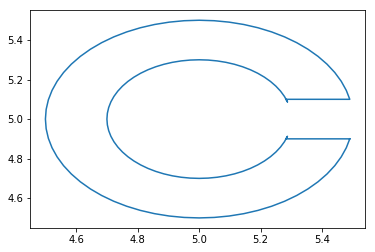

In [42]:
landoltC =  makeLandoltC((5, 5), 1, 0)
xl, yl = landoltC.exterior.xy
plt.plot(xl, yl)

In [4]:
cellfile = 'retina_LE_V.json'
#cellfile = 'retina_LE_E.json'
#cellfile = 'retina_RCS_E.json'
#filename = 'RCS_spikeTimes_cell391.json'
#filename = 'LE_E_spikeTimes_cell301.json'
with open(dsfolder + cellfile,"r") as datafile:
  cell = json.load(datafile)

# counter = 0
# cell = dict()
# for key, val in cell1.items():
#     counter += 1
#     if key == '5311' or key == '5566': cell[key] = val

#print(cell)
dictLists2npArray(cell)

In [5]:
#  === EDIT THIS BLOCK ===
n_output = 2
lum = (0.5, 1)
tol = 0.1
horizBar = (7, 2) #(start, width)
vertBar = (7, 2)
startFrame = 13
# === ===

# 2. 
plotDuration = timeConversion(2, source = 'real', target = 'mea', WNType = 'N')
binWidth = timeConversion(0.01, source = 'real', target = 'mea', WNType = 'N')
nbins = int(plotDuration / binWidth)

popRaster = dict()
spikingPattern = dict()
spikingPattern['info'] = dict()
spikingPattern['info']['stimulusType'] = 'crossbar'


# 3.
stims = dict()

WNType = cell[random.choice(list(cell.keys()))]['experiment']['info']['WNType']

if WNType == 'N': dims = (24,64,32)
else: dims = (24,20,20)

params = dict()
outStim = dict()
for i in range(4):
  params[i] = dict()
  params[i]['center'] = (17,15)#(32, 12) #(17,15)
  params[i]['width'] = 8
  params[i]['angle'] = np.pi/2 * i
  params[i]['startFrame'] = 20
  params[i]['dims'] = dims
  if WNType == 'N':
    outStim[i] = buildBarStimulus2(params[i], visualize = True)
  else:
    #outStim[i] = buildBarStimulus(params[i], visualize = True)
    outStim[i] = buildLandoltCStimulus(params[i], visualize = False)

for j in ('dims','lum','plotDuration','binWidth','nbins', 'tol'):
  spikingPattern['info'][j] = locals()[j]


(17, 15) 8 0.0
(17, 15) 8 1.5707963267948966
(17, 15) 8 3.141592653589793
(17, 15) 8 4.71238898038469


In [5]:
lC_stimulus_file = "G:\My Drive\PalankerLab\\retinal modeling\datasets\landoltc\landoltC_stimulus_dict_V.json"
with open(lC_stimulus_file, 'r') as f_in:
    landoltC_stimulus_dict = json.load(f_in)

In [6]:
#  === EDIT THIS BLOCK ===
center = (14,14)
width = 16

# === ===

# 2. 
plotDuration = timeConversion(2, source = 'real', target = 'mea', WNType = 'N')
binWidth = timeConversion(0.01, source = 'real', target = 'mea', WNType = 'N')
nbins = int(plotDuration / binWidth)

popRaster = dict()
spikingPattern = dict()
spikingPattern['info'] = dict()
spikingPattern['info']['stimulusType'] = 'landoltC'


# 3.
stims = dict()

WNType = cell[random.choice(list(cell.keys()))]['experiment']['info']['WNType']

if WNType == 'N': dims = (24,64,32)
else: dims = (24,20,20)

params = dict()
outStim = dict()
for i in range(4):
    keystring = '(('+ str(center[0]) + ', ' + str(center[1]) + '), ' + str(width) + ', ' + str(i)+ ')'
    outStim[i] = np.array(landoltC_stimulus_dict[keystring]['stimulus'])
    params[i] = np.array(landoltC_stimulus_dict[keystring]['params'])

KeyError: '((14, 14), 16, 0)'

In [7]:
cx = np.arange(10) + 13
cy = np.arange(10) + 10
centerList = np.array([[x, y] for x in cx for y in cy])

#print(centerList)

widthList = 2 * np.arange(8) + 4
#widthList = np.array([10])
angleList = np.arange(4)

params = dict()
outStim = dict()
gen = dict()


for center in centerList:
    for width in widthList:
        for angle in angleList:
            key = composeKeyString(center, width, angle)
            outStim[key] = np.array(landoltC_stimulus_dict[key]['stimulus'])

KeyError: '((13, 10), 4, 0)'

In [8]:
tol = 0.1

plotDuration = timeConversion(2, source = 'real', target = 'mea', WNType = 'N')
binWidth = timeConversion(0.01, source = 'real', target = 'mea', WNType = 'N')
nbins = int(plotDuration / binWidth)

populationRaster = dict()
spikingPattern = dict()
spikingPattern['info'] = dict()
spikingPattern['info']['stimulusType'] = 'landoltC'
counter = 1
flist = os.listdir(dsfolder)

for key, c in cell.items():
    wfn = 'RCS_E_spikingPattern_cell_' + str(key) + '.json'
    print("\n =============================")
    print(f"Computing spiking pattern for cell #{key} ({counter}/{len(cell)})")
    counter += 1
    start_time = time.time()
    if wfn in flist:
        print(f"{wfn} already exists! Skipping...")
        continue
    
    STA = np.array(c['STA'])

    MEAN = np.mean(STA)
    MAX = np.max(STA)
    MIN = np.min(STA)
    kernel = (STA - MEAN) / (MAX - MIN)

    gen = dict()
    populationRaster[key] = dict()
    generator = c['generator']
    experiment = c['experiment']
    raster = dict()
    spikingPattern = dict()
    
    for stimKey, stim in outStim.items():
        gen[stimKey] = np.sum(np.multiply(kernel,stim), axis = None)
        #print(f"Generator for {stimKey}: {gen[stimKey]}")

        populationRaster[key][stimKey], idx_h = rasterFromGenerator(experiment, generator, (gen[stimKey], tol), plotDuration)
        raster[stimKey] = np.array([k for i,k in populationRaster[key][stimKey].items()])
        norm = np.average([len(aa) for aa in raster[stimKey]])/nbins
        raster[stimKey] = timeConversion(np.concatenate(raster[stimKey]).ravel(), source = "mea", target = "real", WNType = experiment['info']['WNType'])

        spikingPattern[stimKey] = dict()
        spikingPattern[stimKey], _, _ = stats.binned_statistic(raster[stimKey],
                                                           np.ones_like(raster[stimKey]) * norm / len(raster[stimKey]),
                                                           statistic = 'sum',
                                                           bins = nbins)
        spikingPattern[stimKey] = spikingPattern[stimKey].tolist()

    with open(dsfolder + wfn,'w') as f_out:
        json.dump(spikingPattern, f_out)

    end_time = time.time()
    print(f'Elapsed time: {end_time - start_time} secs')


Computing spiking pattern for cell #301 (1/49)
Elapsed time: 0.009973287582397461 secs

Computing spiking pattern for cell #5328 (2/49)
Elapsed time: 0.014960765838623047 secs

Computing spiking pattern for cell #5447 (3/49)
Elapsed time: 0.014958620071411133 secs

Computing spiking pattern for cell #4276 (4/49)
Elapsed time: 0.013962745666503906 secs

Computing spiking pattern for cell #5147 (5/49)
Elapsed time: 0.011970996856689453 secs

Computing spiking pattern for cell #5192 (6/49)
Elapsed time: 0.01296234130859375 secs

Computing spiking pattern for cell #5206 (7/49)
Elapsed time: 0.012965917587280273 secs

Computing spiking pattern for cell #4771 (8/49)
Elapsed time: 0.013962030410766602 secs

Computing spiking pattern for cell #4051 (9/49)
Elapsed time: 0.01296544075012207 secs

Computing spiking pattern for cell #5117 (10/49)
Elapsed time: 0.010970592498779297 secs

Computing spiking pattern for cell #4861 (11/49)
Elapsed time: 0.00997304916381836 secs

Computing spiking patt

In [9]:
# for k,v in spikingPattern.items():
#     spikingPattern[k] = spikingPattern[k].tolist()
with open('./LE_V_spikingPattern_cell_' + str(key) + '.json','w') as f_out:
    json.dump(spikingPattern, f_out)

In [10]:
flist

NameError: name 'flist' is not defined

In [31]:
tol = 0.15
# popRaster = dict()
# spikingPattern = dict()
# spikingPattern['info'] = dict()
# spikingPattern['info']['stimulusType'] = 'crossbar'
# for i in ('dims','lum','horizBar','vertBar','plotDuration','binWidth','nbins', 'tol'):
#   spikingPattern['info'][i] = locals()[i]
start_time = time.time()
cmap_list = {0: plt.cm.Blues,
             1: plt.cm.Oranges,
             2: plt.cm.Greens,
             3: plt.cm.Reds}
counter = 0
for key, c in cell.items():

  print(key)
  
  STA = np.array(c['STA'])

  MEAN = np.mean(STA)
  MAX = np.max(STA)
  MIN = np.min(STA)
  kernel = (STA - MEAN) / (MAX - MIN)
  
  gen = dict()
  
    
  for i in range(len(outStim)):
    gen[i] = np.sum(np.multiply(kernel,outStim[i]), axis = None)
    #print(f"Generator {i}: {gen[i]}")
  
  popRaster[key] = dict()
  generator = c['generator']
  experiment = c['experiment']
  rasterFlat = dict()
  x1 = dict()
  spikingPattern[key] = dict()

  for i in range(len(outStim)):
    popRaster[key][i], idx_h = rasterFromGenerator(experiment, generator, (gen[i], tol), plotDuration)
    rasterFlat[i] = np.array([j for i,k in popRaster[key][i].items() for j in k]).flatten()
    rasterFlat[i] = timeConversion(rasterFlat[i], source = "mea", target = "real", WNType = experiment['info']['WNType'])
    
    spikingPattern[key][i] = dict()
    x1[i] = dict()
    spikingPattern[key][i], x1[i] = np.histogram(rasterFlat[i],
                bins = nbins,
                weights = np.ones_like(rasterFlat[i])/len(rasterFlat[i]))
  
#   plt.subplot(1,2,1)
#   plt.imshow(STA[np.unravel_index(np.argmax(STA, axis = None), STA.shape)[0],:,:], cmap=plt.cm.gray)
#   for i in range(len(outStim)):
#     plt.imshow(outStim[i][-1,:,:], alpha = 0.2, cmap = cmap_list[i])

#     hist1 = plt.hist(rasterFlat[i],
#             bins = nbins,
#             alpha = 0.8,
#             weights=np.ones_like(rasterFlat[i])/len(rasterFlat[i]),
#             histtype = 'stepfilled')

#   plt.subplot(1,2,2)
#   for i in range(len(outStim)):
#     plt.plot((x1[i][1:] + x1[i][:-1]) / 2, spikingPattern[key][i])
#     #plt.plot(spikingPattern[key][i])

#   plt.xlim((0, 1))
#   plt.show()
end_time = time.time()
print(f"Elapsed time: {end_time - start_time} secs")

301


TypeError: 'Macro' object is not callable

In [10]:
spikePatternFiles = []
for fs in os.listdir(dsfolder):
    if 'LE_V_spikingPattern' in fs:
        spikePatternFiles.append(fs)
print(spikePatternFiles)
# with open(spikePatternFiles[0], 'r') as ftemp:
#     print(json.load(ftemp))

['LE_V_spikingPattern_cell_1096.json', 'LE_V_spikingPattern_cell_1277.json', 'LE_V_spikingPattern_cell_1231.json', 'LE_V_spikingPattern_cell_1397.json', 'LE_V_spikingPattern_cell_1502.json', 'LE_V_spikingPattern_cell_1592.json', 'LE_V_spikingPattern_cell_1516.json', 'LE_V_spikingPattern_cell_3886.json', 'LE_V_spikingPattern_cell_1622.json', 'LE_V_spikingPattern_cell_1861.json', 'LE_V_spikingPattern_cell_1801.json', 'LE_V_spikingPattern_cell_3226.json', 'LE_V_spikingPattern_cell_994.json', 'LE_V_spikingPattern_cell_842.json', 'LE_V_spikingPattern_cell_781.json', 'LE_V_spikingPattern_cell_436.json', 'LE_V_spikingPattern_cell_557.json', 'LE_V_spikingPattern_cell_271.json', 'LE_V_spikingPattern_cell_241.json', 'LE_V_spikingPattern_cell_437.json', 'LE_V_spikingPattern_cell_378.json', 'LE_V_spikingPattern_cell_559.json', 'LE_V_spikingPattern_cell_992.json', 'LE_V_spikingPattern_cell_632.json', 'LE_V_spikingPattern_cell_692.json', 'LE_V_spikingPattern_cell_4307.json', 'LE_V_spikingPattern_cel

In [11]:
cell_ids = [cellName.split('_')[4].split('.')[0] for cellName in spikePatternFiles]
print(cell_ids)

['1096', '1277', '1231', '1397', '1502', '1592', '1516', '3886', '1622', '1861', '1801', '3226', '994', '842', '781', '436', '557', '271', '241', '437', '378', '559', '992', '632', '692', '4307', '4066', '5297', '5296', '5148', '4981', '4636', '4726', '4516', '4096', '4039', '4531', '5193', '4861', '5117', '4051', '4771', '5206', '5192', '5147', '4276', '5447', '5328', '301']


In [12]:
num_exp = 10000
c_location = np.array(list(zip(np.random.choice(cx, num_exp), np.random.choice(cy, num_exp))))
print(c_location)
print(c_location.shape)



[[22 15]
 [16 19]
 [21 18]
 ...
 [13 13]
 [17 14]
 [21 18]]
(10000, 2)


In [14]:
num_exp = 10000
num_cells = len(spikePatternFiles)
cell_ids = [cellName.split('_')[4].split('.')[0] for cellName in spikePatternFiles]

plotDuration = timeConversion(2, source = 'real', target = 'mea', WNType = 'N')
binWidth = timeConversion(0.01, source = 'real', target = 'mea', WNType = 'N')
nbins = int(plotDuration / binWidth)

#info = spikingPattern['info']
binWidth = timeConversion(binWidth, source = 'mea', target = 'real')
synthTime = 0.5
lastBinEdge = int(synthTime / binWidth)
print(lastBinEdge)

synthData = np.zeros((num_exp, num_cells))
synthLabel = np.round(4 * np.random.random((num_exp,)) - 0.5).astype(int)
synthDataLong = np.zeros((num_exp, num_cells * lastBinEdge))

spikeRate = np.zeros((num_exp, num_cells, lastBinEdge))
count = 0

print(f"Number of cells: {num_cells}")
print(f"List of cell IDs: {[cid for cid in cell_ids]}")

c_location = np.array(list(zip(np.random.choice(cx, num_exp), np.random.choice(cy, num_exp))))
c_size = 16
#centerList, widthList, angleList

for i, fn in enumerate(spikePatternFiles):
    with open(dsfolder + fn, 'r') as ftemp:
        cellPattern = json.load(ftemp)
    print(f"On file {fn} ({i+1}/{num_cells})")
    #print(cellPattern.keys())
    for n_e in range(num_exp):
        if n_e % 2500 == 0: print(f"On exp #{n_e}")
        key = composeKeyString(c_location[n_e], c_size, synthLabel[n_e])
        spikeRate[n_e, i, :] = cellPattern[key][:lastBinEdge] / binWidth
        #sigma = np.std(spikeRate[n_e, i, :])
        mu = spikeRate[n_e, i, :] #- np.average(sigma, axis = None)
        rng = np.random.rand(*(spikeRate[n_e, i, :].shape))
        rng = (rng < mu).astype(int)
        synthDataLong[n_e, i*lastBinEdge:(i+1)*lastBinEdge] = rng
        synthData[n_e, i] = np.sum(rng, axis = None)


# for key, val in cell.items():
#   #orientation = 
#   for i in range(len(outStim)):
#     spikeRate[i, count, :] = spikingPattern[key][i][:lastBinEdge] / binWidth
#   count += 1


# for n_e in range(num_exp):
#   if n_e % 2500 == 0: print(f"Simulating experiment #{n_e}")
#   orientation = int(synthLabel[n_e])
#   sigma = np.tile(np.std(spikeRate[orientation, :, :], axis = 1).T, (lastBinEdge,1)).T
# #     print(sigma)
#   mu = spikeRate[orientation, :, :] - np.average(sigma, axis = None)
# #     print(mu)
#   rng = sigma * np.random.random(spikeRate[orientation, :, :].shape) + mu
#   synthDataLong[n_e, :, :] = rng
#   synthData[n_e, :] = np.sum(rng, axis = 1)

#print(f"Synthetic data shape: {synthData.shape}")
#print(synthLabel)
#synthLabel = F.one_hot(torch.from_numpy(synthLabel.astype(int)), 2)
#     plt.figure
#     plt.plot(np.arange(spikeRate.shape[0]) * binWidth, rng)
#     plt.show()
    
    #print(spikeDistrib)

50
Number of cells: 49
List of cell IDs: ['1096', '1277', '1231', '1397', '1502', '1592', '1516', '3886', '1622', '1861', '1801', '3226', '994', '842', '781', '436', '557', '271', '241', '437', '378', '559', '992', '632', '692', '4307', '4066', '5297', '5296', '5148', '4981', '4636', '4726', '4516', '4096', '4039', '4531', '5193', '4861', '5117', '4051', '4771', '5206', '5192', '5147', '4276', '5447', '5328', '301']
On file LE_V_spikingPattern_cell_1096.json (1/49)
On exp #0


KeyError: '((16, 16), 16, 2)'

In [ ]:
plt.figure
nth_cell = 10

plt.figure(figsize=(2, 6))
idx_ori = dict()
for i in range(len(outStim)):
  idx_ori[i] = np.where(synthLabel == i)[0]
  plt.subplot(len(outStim),1,i+1)
  plt.plot(np.sum(synthDataLong[idx_ori[i],nth_cell,:], axis = 0)/len(idx_ori[i]))
  plt.plot(spikeRate[i,nth_cell,:])

C:\Users\elton\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


KeyboardInterrupt: 

In [59]:
# 0. hyperparameters
LR = 0.005
NUM_EPOCH = 50
MINIBATCH_SIZE = 128
TRAIN_FRACTION = 0.8
L2_WEIGHT = 0.01
L1_WEIGHT = 0.001
STOP_EPSILON = 0.001

DEVICE = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

# 1. model
class denseNet(nn.Module):

  def __init__(self, n_in, n_out):
    super(denseNet, self).__init__()
    self.subunits = (15, 15)
    self.linear1 = nn.Linear(n_in, self.subunits[0])
    self.relu1 = nn.ReLU()
    self.linear2 = nn.Linear(self.subunits[0], self.subunits[1])
    self.relu2 = nn.ReLU()
    self.linear3 = nn.Linear(self.subunits[1], n_out)
    self.relu3 = nn.ReLU()
    self.softmax = nn.Softmax()
    
    self.model_type = 'dense'

  def forward(self, x):
    out = self.linear1(x)
    out = self.relu1(out)
    out = self.linear2(out)
    out = self.relu2(out)
    out = self.linear3(out)
    out = self.relu3(out)
    out = self.softmax(out)
    return out

class linearDecoder(nn.Module):

  def __init__ (self, n_in, n_out):
    super(linearDecoder, self).__init__()
    self.linear = nn.Linear(n_in, n_out)
    #self.tanh = nn.Tanh()
    self.relu = nn.ReLU()
    self.softmax = nn.Softmax(dim = None)
    
    self.model_type = 'linear'

  def forward(self, x):
    out = self.linear(x)
    #out = self.tanh(out)
    out = self.relu(out)
    out = self.softmax(out)
    return out

def weights_init(model):
    if model.model_type == 'linear':
        nn.init.xavier_normal_(model.linear.weight)
    if model.model_type == 'dense':
        nn.init.xavier_normal_(model.linear1.weight)
        nn.init.xavier_normal_(model.linear2.weight)
  #nn.init.xavier_normal_(model.linear2.weight)

#model = linearDecoder(num_cells * lastBinEdge, 4).to(DEVICE)
#weights_init(model)
model = denseNet(num_cells * lastBinEdge, 4).to(DEVICE)
weights_init(model)

#torch.nn.init.xavier_uniform_(model.linear.weight)
print(model)
params = list(model.parameters())
for key, p in enumerate(params):
  print(f"{key}: {p.size()}")

# Regularization functions

def L2Regularization(model):
    if model.model_type == 'linear':
        return np.sum(model.linear.weight.data.cpu().detach().numpy() ** 2)
    if model.model_type == 'dense':
        return np.sum(model.linear1.weight.data.cpu().detach().numpy() ** 2) \
            + np.sum(model.linear2.weight.data.cpu().detach().numpy() ** 2) \
            + np.sum(model.linear3.weight.data.cpu().detach().numpy() ** 2)

def L1Regularization(model):
    if model.model_type == 'linear':
        return np.sum(np.abs(model.linear.weight.data.cpu().detach().numpy()))

# 2. loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = LR, betas = (0.9, 0.999))
#optimizer = optim.SGD(model.parameters(), lr = LR)

# 3. Load data
class compileData(Dataset):

  def __init__(self, X, Y):
    if not torch.is_tensor(X): self.X = torch.from_numpy(X)
    else: self.X = X
    if not torch.is_tensor(Y): self.Y = torch.from_numpy(Y)
    else: self.Y = Y
  
  def __len__(self):
    return len(self.Y)

  def __getitem__(self, idx):
    return self.X[idx, :], self.Y[idx]

ds = compileData(X = synthData, Y = synthLabel)

denseNet(
  (linear1): Linear(in_features=950, out_features=15, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=15, out_features=15, bias=True)
  (relu2): ReLU()
  (linear3): Linear(in_features=15, out_features=4, bias=True)
  (relu3): ReLU()
  (softmax): Softmax()
)
0: torch.Size([15, 950])
1: torch.Size([15])
2: torch.Size([15, 15])
3: torch.Size([15])
4: torch.Size([4, 15])
5: torch.Size([4])


In [60]:
X = torch.from_numpy(synthDataLong.astype(float))

a = synthLabel.astype(int)
b = np.zeros((len(a), 4))
b[np.arange(len(a)), a] = 1
Y = torch.from_numpy(b)

#Y = F.one_hot(torch.from_numpy(synthLabel.astype(int)), len(outStim))

train_size = int(TRAIN_FRACTION * num_exp)
dev_size = num_exp - train_size
X_train = X[:train_size, :]
Y_train = Y[:train_size]
X_dev = X[train_size:, :]
Y_dev = Y[train_size:]

trainset = TensorDataset(X_train, Y_train)
devset = TensorDataset(X_dev, Y_dev)

train_loader = DataLoader(dataset = trainset,
                             batch_size = MINIBATCH_SIZE,
                             shuffle=True,
                             pin_memory=True)

dev_loader = DataLoader(dataset = devset,
                             batch_size = MINIBATCH_SIZE,
                             pin_memory=True)

C:\Users\elton\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch #0  	--  Train loss: 260.6387869119644 	 Train Acc: 0.75 	 Dev Acc: 0.75
Epoch #1  	--  Train loss: 260.16411900520325 	 Train Acc: 0.75103125 	 Dev Acc: 0.7498333333333334
Epoch #2  	--  Train loss: 257.7788749933243 	 Train Acc: 0.75871875 	 Dev Acc: 0.722125
Epoch #3  	--  Train loss: 252.49364173412323 	 Train Acc: 0.76534375 	 Dev Acc: 0.7034583333333333
Epoch #4  	--  Train loss: 246.924076795578 	 Train Acc: 0.7728020833333333 	 Dev Acc: 0.694125
Epoch #5  	--  Train loss: 241.85270977020264 	 Train Acc: 0.77453125 	 Dev Acc: 0.675125
Epoch #6  	--  Train loss: 238.0025144815445 	 Train Acc: 0.7776666666666666 	 Dev Acc: 0.6657083333333333
Epoch #7  	--  Train loss: 234.82211101055145 	 Train Acc: 0.77984375 	 Dev Acc: 0.662625
Epoch #8  	--  Train loss: 232.3485884666443 	 Train Acc: 0.7918645833333333 	 Dev Acc: 0.6690416666666666
Epoch #9  	--  Train loss: 230.38720190525055 	 Train Acc: 0.7919166666666667 	 Dev Acc: 0.6655
Epoch #10  	--  Train loss: 228.84870970249176

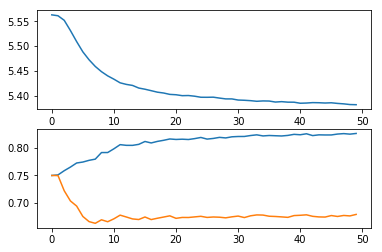

In [61]:
num_minibatches = len(train_loader)
losses = []
total_losses = []
accs = []
train_prediction = np.zeros_like(Y_train)
dev_prediction = np.zeros_like(Y_dev)
train_confidence = np.zeros_like(Y_train)
dev_confidence = np.zeros_like(Y_dev)

for epoch in range(NUM_EPOCH):

  #indices = np.random.permutation(epoch_train_x.shape[0]).astype('int')

  total_loss = 0

  for minibatch_X, minibatch_Y in train_loader:

    #idxs = indices[MINIBATCH_SIZE*minibatch: MINIBATCH_SIZE*(minibatch+1)]
    minibatch_X, minibatch_Y = minibatch_X.to(DEVICE), minibatch_Y.to(DEVICE)

    yhat = model(minibatch_X.float())
    
        #_, targets = minibatch_Y.max(dim=1)
    targets = torch.LongTensor(torch.argmax(minibatch_Y, 1))
    loss = criterion(yhat, Variable(targets)) #+ L2_WEIGHT * L2Regularization(model)#+ L1_WEIGHT * L1Regularization(model)
        #loss = criterion(yhat, minibatch_Y.float())
    #acc = torch.eq(yhat.round(), minibatch_Y).float().mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss)
    #accs.append(acc)

    total_loss += loss.item()

  model.eval()

  train_acc = 0
  train_prediction = np.round(model(X_train.to(DEVICE).float()).cpu().detach().numpy()).astype(int)
  train_confidence = model(X_train.to(DEVICE).float()).cpu().detach().numpy()
  # for minibatch_n, (train_X, train_Y) in enumerate(train_loader):
  #   train_prediction[minibatch_n * MINIBATCH_SIZE: (minibatch_n + 1) * MINIBATCH_SIZE] = model(train_X.to(DEVICE).float()).cpu().detach().numpy()

  dev_prediction = np.round(model(X_dev.to(DEVICE).float()).cpu().detach().numpy()).astype(int)
  dev_confidence = model(X_dev.to(DEVICE).float()).cpu().detach().numpy()
  # for minibatch_n, (dev_X, _) in enumerate(dev_loader):
  #   dev_prediction[minibatch_n * MINIBATCH_SIZE: (minibatch_n + 1) * MINIBATCH_SIZE] = model(dev_X.to(DEVICE).float()).cpu().detach().numpy()

  #print(np.equal(train_prediction, Y_train.numpy))
  train_acc = np.sum(np.equal(train_prediction, Y_train.numpy()).astype(int)) / train_size / 4
  dev_acc = np.sum(np.equal(dev_prediction, Y_dev.numpy()).astype(int)) / dev_size / 4

  accs.append([train_acc, dev_acc])

  total_losses.append(total_loss)

  print(f"Epoch #{epoch}  \t--  Train loss: {total_loss} \t Train Acc: {train_acc} \t Dev Acc: {dev_acc}")

accs = np.array(accs)

plt.figure
plt.subplot(2,1,1)
plt.plot(np.log(total_losses))

plt.subplot(2,1,2)
plt.plot(accs[:,0])
plt.plot(accs[:,1])

    # if epoch % 1 == 0:
    #     print("[{}/{}], loss: {} acc: {}".format(epoch,
    #     num_epoch, loss, acc))
    

In [17]:
num_test = 1000
num_cells = len(cell)
info = spikingPattern['info']
binWidth = timeConversion(info['binWidth'], source = 'mea', target = 'real')
testTime = 0.5
lastBinEdge = int(testTime / binWidth)

testData = np.zeros((num_test, num_cells))
testLabel = np.round(len(outStim) * np.random.random((num_test,)) - 0.5)
testDataLong = np.zeros((num_test, num_cells, lastBinEdge))

spikeRate_test = np.zeros((len(outStim), num_cells, lastBinEdge))
count = 0

print(f"Number of cells: {len(cell.keys())}")
print(f"List of cell IDs: {[k for k in cell.keys()]}")

for key, val in cell.items():
  #orientation = 
  for i in range(len(outStim)):
    spikeRate_test[i, count, :] = spikingPattern[key][i][:lastBinEdge] / binWidth
  count += 1


for n_e in range(num_test):
  if n_e % 2500 == 0: print(f"Simulating test #{n_e}")
  orientation = int(testLabel[n_e])
  sigma = np.tile(np.std(spikeRate_test[orientation, :, :], axis = 1).T, (lastBinEdge,1)).T
#     print(sigma)
  mu = spikeRate_test[orientation, :, :] - np.average(sigma, axis = None)
#     print(mu)
  rng = sigma * np.random.random(spikeRate_test[orientation, :, :].shape) + mu
  testDataLong[n_e, :, :] = rng
  testData[n_e, :] = np.sum(rng, axis = 1)
    
    
X_test = torch.from_numpy(testData.astype(float))
Y1 = testLabel.astype(int)
Y2 = np.zeros((len(Y1), len(outStim)))
Y2[np.arange(len(Y1)), Y1] = 1
Y_test = torch.from_numpy(Y2)


test_prediction = np.round(model(X_test.to(DEVICE).float()).cpu().detach().numpy()).astype(int)
test_confidence = model(X_test.to(DEVICE).float()).cpu().detach().numpy()

test_acc = np.sum(np.equal(test_prediction, Y_test.numpy()).astype(int)) / num_test / len(outStim)
print(f"Test accuracy: {test_acc}")

Number of cells: 19
List of cell IDs: ['5086', '4921', '5071', '5236', '5536', '5386', '5101', '4397', '4711', '4741', '4231', '4141', '661', '841', '3961', '3977', '4126', '557', '361']


KeyError: '5086'

In [48]:
Y.shape
print(f"Size minibatch: {minibatch_Y.shape}, size targets:{targets.shape}")
print(minibatch_Y[1:10,:])
print(targets[1:10])
print(yhat[1:10])
#yhat, Variable(targets)

Size minibatch: torch.Size([320, 4]), size targets:torch.Size([320])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 1., 0.]], dtype=torch.float64)
tensor([0, 0, 2, 2, 1, 0, 0, 0, 2])
tensor([[9.7576e-01, 2.3459e-02, 7.8577e-04, 2.7276e-12],
        [9.8797e-01, 1.1944e-02, 8.0996e-05, 1.4663e-12],
        [1.6612e-05, 1.9228e-06, 9.9998e-01, 8.4117e-13],
        [6.9175e-07, 2.6008e-05, 9.9997e-01, 6.9366e-14],
        [2.4682e-06, 8.6808e-01, 1.3191e-01, 1.9613e-12],
        [9.0401e-01, 1.5768e-03, 9.4412e-02, 5.7042e-12],
        [1.0000e+00, 1.1951e-06, 2.4772e-07, 2.0962e-13],
        [9.9874e-01, 1.2638e-03, 3.3908e-07, 2.7991e-13],
        [9.4450e-02, 1.3261e-05, 9.0554e-01, 4.8113e-11]],
       grad_fn=<SliceBackward>)


In [49]:
print(train_prediction[:,:])
print(Y_train)

[[0 0 1 0]
 [0 1 0 0]
 [0 0 1 0]
 ...
 [0 0 1 0]
 [0 1 0 0]
 [0 1 0 0]]
tensor([[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        [0., 1., 0., 0.]], dtype=torch.float64)


Stats:
Mean error: 0.062153179198503494
Std error: 0.06353706866502762


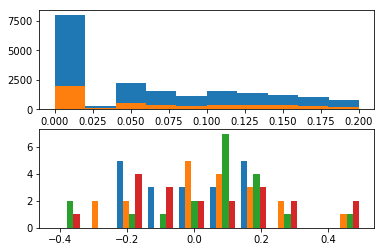

In [106]:
plt.subplot(2,1,1)
plt.hist(train_confidence[train_confidence < 0.2])
plt.hist(dev_confidence[dev_confidence < 0.2])
plt.subplot(2,1,2)
plt.hist(model.linear.weight.data.cpu())
print("Stats:")
print(f"Mean error: {np.average(train_confidence[train_confidence < 0.2])}")
print(f"Std error: {np.std(train_confidence[train_confidence < 0.2])}")

In [31]:
output_dict = {"Accuracy": accs.tolist(),
              "Losses": total_losses,
              "Train_Confidence": train_confidence.tolist(),
              "Dev_Confidence": dev_confidence.tolist(),
              "Weights": model.linear.weight.data.cpu().tolist()}

output_json = json.dumps(output_dict)

jsonfile = "G:\\My Drive\\PalankerLab\\retinal modeling\\datasets\\retina_RCS_E_4bar.json"
with open(jsonfile,'w') as f:
    json.dump(output_dict, f)